In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Tuple

import chex
from gymnax import EnvParams, EnvState

import os
import sys
import argparse

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
import gymnax
import optax
import flax
import flax.linen as nn
import pickle
import json
from jax.random import split
from functools import partial

import run
import run_bc
import util

from agents.basic import RandomAgent
from algos.ppo_dr import PPO

In [3]:
from mdps.random_net import RandomMLP, create_random_net

In [4]:
rng = jax.random.PRNGKey(0)

2024-02-13 22:34:00.327630: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


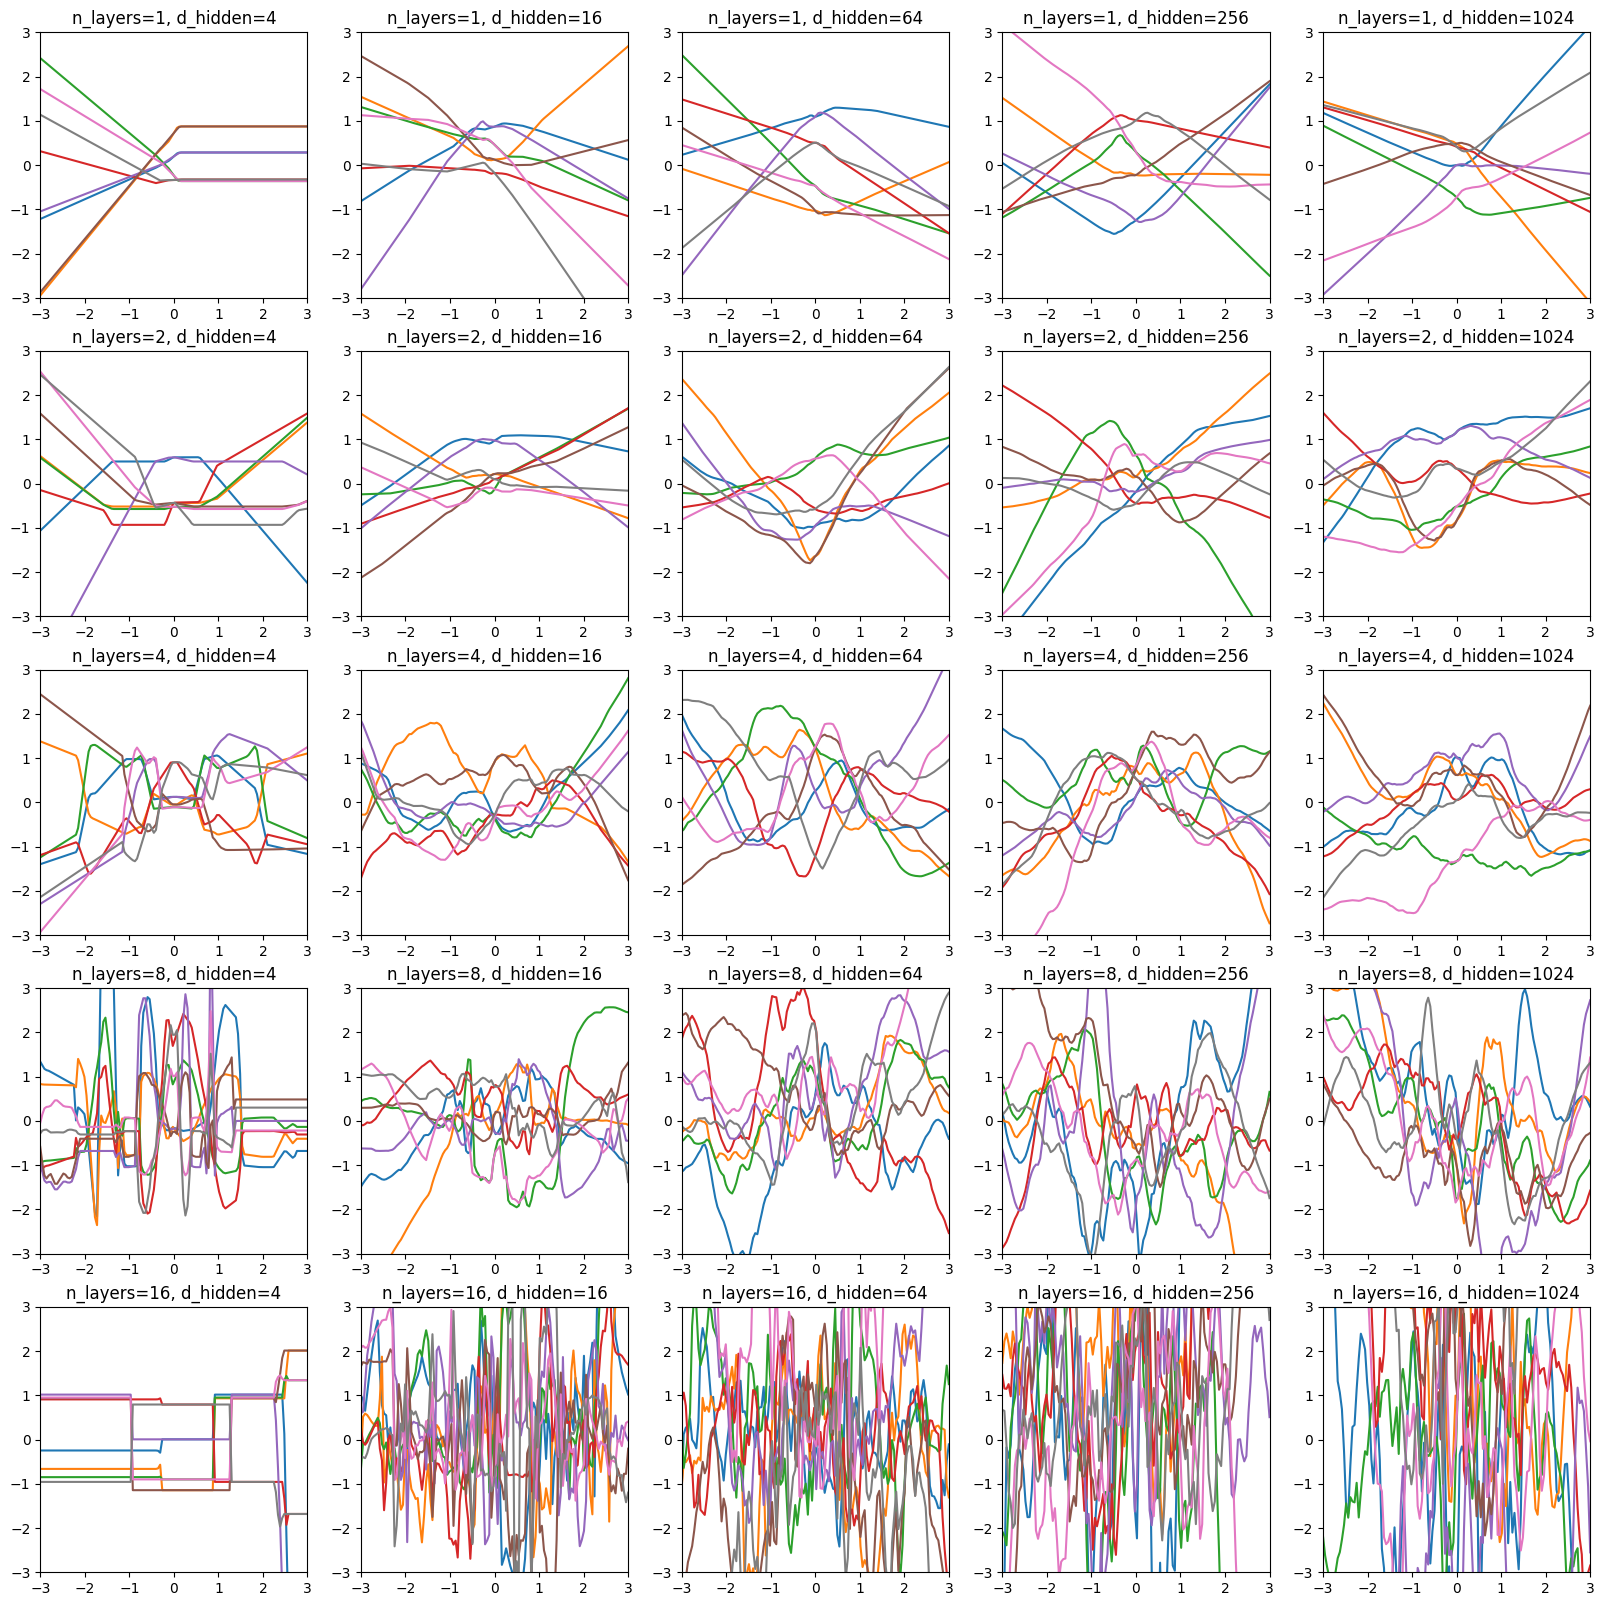

In [6]:
plt.figure(figsize=(20, 20))
for i1, n_layers in enumerate([1, 2, 4, 8, 16]):
    for i2, d_hidden in enumerate([4, 16, 64, 256, 1024]):
        plt.subplot(5, 5, i1*5+i2+1)
        d_in, d_out = 4, 4
        activation = nn.relu
        net = RandomMLP(n_layers=n_layers, d_hidden=d_hidden, d_out=d_out, activation=activation)
        
        rng, _rng = split(rng)
        x = jax.random.normal(_rng, (32, d_in))
        rng, _rng = split(rng)
        params = create_random_net(net, _rng, x)

        t = jnp.linspace(-1, 1, 128)*3
        def get_nn_slice(rng):
            rng, _rng = split(rng)
            v = jax.random.normal(_rng, (d_in, ))
            v = v/jnp.linalg.norm(v)
            x = t[:, None] * v

            y = jax.vmap(net.apply, in_axes=(None, 0))(params, x)
            y = rearrange(y, 't d -> d t')
            return y

        rng, _rng = split(rng)
        y = jax.vmap(get_nn_slice)(split(_rng, 2))
        y = rearrange(y, 'b1 b2 t -> (b1 b2) t')
        plt.plot(t, y.T)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.title(f'n_layers={n_layers}, d_hidden={d_hidden}')


In [13]:
net = RandomMLP(n_layers=4, d_hidden=64, d_out=4, activation=nn.relu)

In [31]:
def fixed_orthogonal_projection(d_in, d_out):
    rng = jax.random.PRNGKey(0)
    mat = jax.random.orthogonal(rng, n=max(d_in, d_out), shape=())
    return mat[:d_out, :d_in]

In [115]:
def viz_pretraining(d):
    # print(os.listdir(d))
    with open(f'{d}/metrics_before.pkl', 'rb') as f:
        metrics_before = pickle.load(f)
    with open(f'{d}/metrics_train.pkl', 'rb') as f:
        metrics_train = pickle.load(f)
    with open(f'{d}/metrics_after.pkl', 'rb') as f:
        metrics_after = pickle.load(f)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(metrics_train['ce'].mean(axis=-1), label='training')
    plt.plot(metrics_train['tar_entr'].mean(axis=-1), label='expert', c='black')
    plt.ylabel("CE Loss"); plt.xlabel("Training Steps"); plt.legend()
    plt.subplot(122)
    plt.plot(metrics_before['ce'].mean(axis=0), label='before training', c='r')
    plt.plot(metrics_after['ce'].mean(axis=0), label='after training', c='g')
    plt.plot(metrics_after['tar_entr'].mean(axis=0), label='expert', c='black')
    plt.ylabel("CE Loss"); plt.xlabel("In-Context Length"); plt.legend()
    plt.tight_layout()
    plt.show()

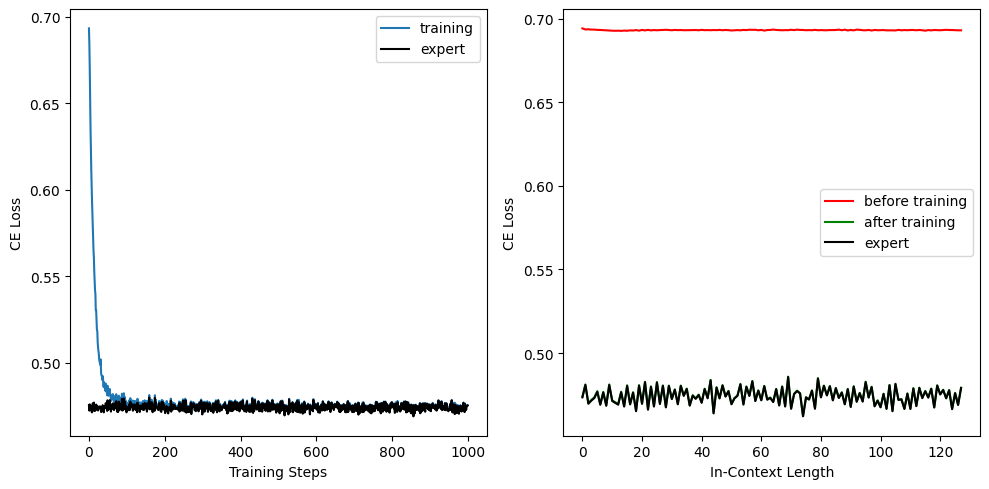

In [111]:
# no augmentations
viz_pretraining("../data/exp_icl/train_bc/name=CartPole-v1/")

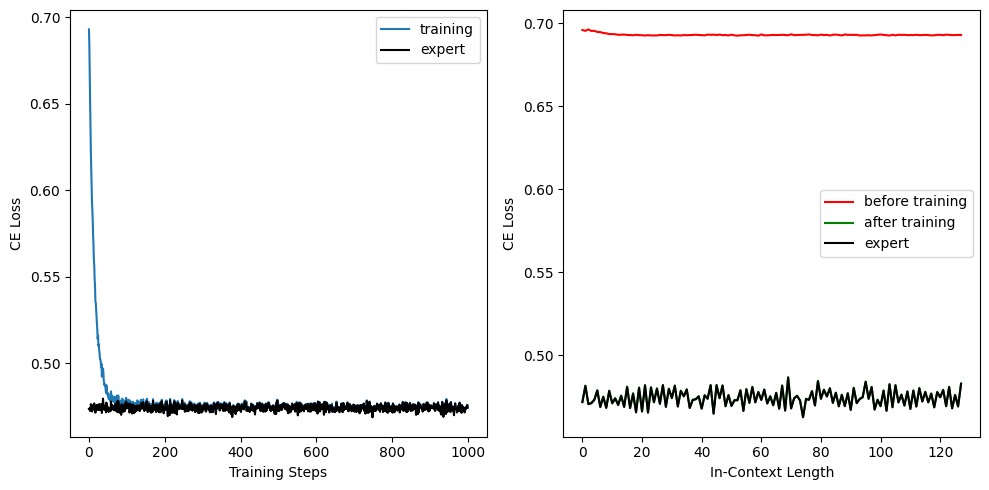

In [117]:
# 1 augmentations
viz_pretraining("../data/exp_icl/train_bc/name=CartPole-v1/")

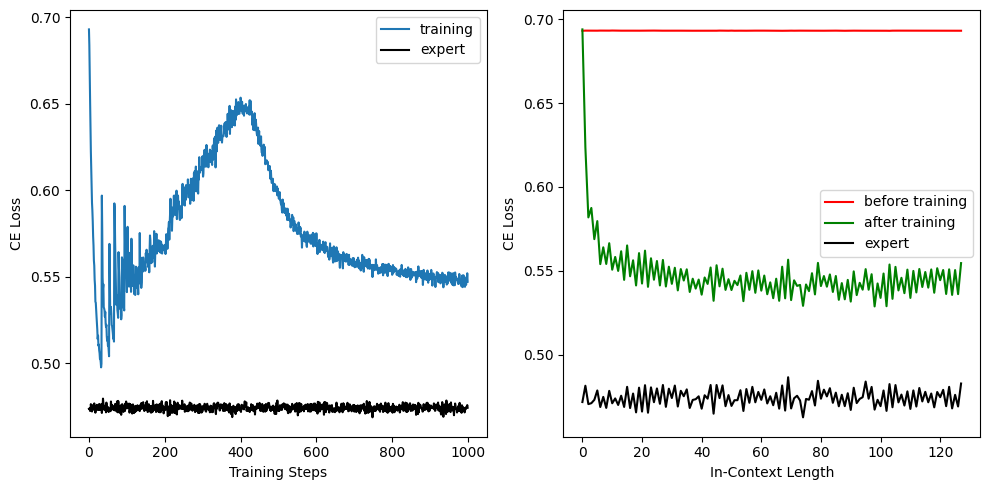

In [118]:
# curriculum to 1e9 augmentations
viz_pretraining("../data/exp_icl/train_bc/name=CartPole-v1/")

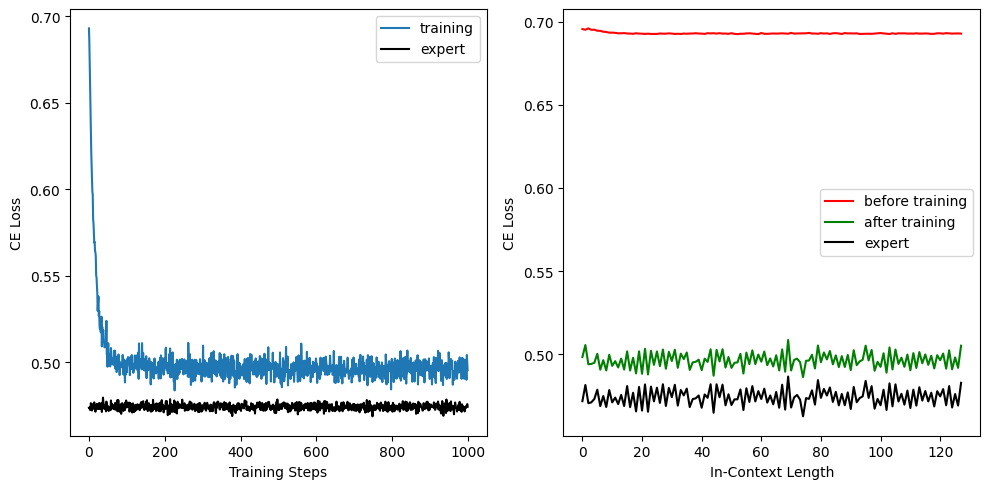

In [119]:
# 10% percent augmentations
viz_pretraining("../data/exp_icl/train_bc/name=CartPole-v1/")


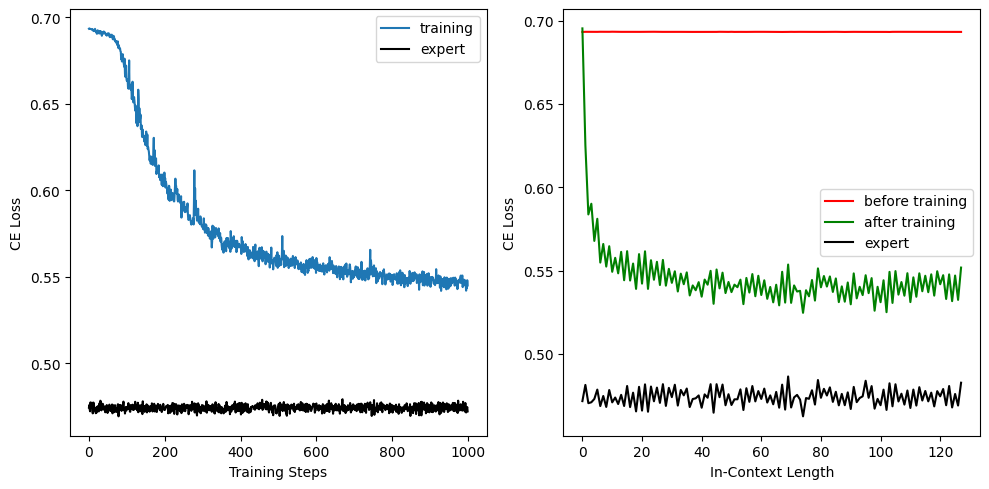

In [109]:
viz_pretraining("../data/exp_icl/train_bc/name=CartPole-v1/")